# Iterative Update Rule + Bernstein Inequality

**Update rule:**

$\hat{Q}(\lambda,\lambda')=\hat{L}(\lambda,\lambda')+\tau \max(\lambda-\lambda',0)+B(N,\delta/T)-\alpha$

$\lambda^{(t+1)}=\min(\lambda^{(t)}, \inf\{\lambda: \hat{Q}(\lambda^{(t-1)},\lambda) \leq0  \})$

Stopping rule: $\lambda^{(t+1)} > \lambda^{(t)}- \Delta \lambda$

**Implementation details**
- Computing $B(N,\delta/T)$: We need a uniform bound over all distributional $\lambda$. This quantity is computed as two times the unbiased variance when the distributional $\lambda$ is $\lambda^{(0)}=1$. Why two? I think two is quite generous, as this assumes the maximum variance induced by different $\lambda$ increases at most by a factor of two (including some estimation error).
- Implementing **$\gamma$-sensitivity**: Recall that $\gamma$-sensitivity gives us $|\mathbb{E}_{z \sim \mathcal{D}(\lambda_1)}[l(z, \lambda)] - \mathbb{E}_{z \sim \mathcal{D}(\lambda_2)}[l(z, \lambda)]| \leq \gamma L |\lambda_1 - \lambda_2|$. Since only $\hat{y}$ is directly related to the loss, we assume some change in the features (that we don't calculate) that would give us an $\gamma$ shift in $\hat{y}$. Only actors whose utility, as defined as the negative of the institution loss, increases will shift. In this way, we get different mappings for different $\lambda$'s.
- We guarantee risk control at level `alpha` with tightness `tightness`. This means that w.h.p., the population loss is between `alpha - tightness` and `alpha`.

**Results:**

### Set up

In [3]:
# Experimental setup arguments

class args:
    alpha = 0.2         # risk control level
    tightness = 0.08    # tightness parameter, may throw error if too low
    delta = 0.1         # failure probability or confidence parameter

    tau = 1.            # safety parameter
    L = 5              # Lipschitz constant

    gamma = 0.2        # sensitivity constant, must be <= tau / L from the theory
    # epsilon = 0.2        # sensitivity constant, must be <= tau / L from the theory
    # Note that this is quite large! An actor can shift their y_hat by epsilon!

    N = 3000            # number of samples in cohort

    lambda_max = 1.0    # maximum value for lambda

    # To calculate after the first round
    # delta_lambda      # max difference in lambda between consecutive rounds to guarantee tightness
    # T                 # number of rounds needed for theoretical guarantee
    # sigma_sq          # upper bound on variance on any distributional parameter lambda
    # C_gamma           # upper bound on the PDF of the initial data distribution
    # C = gamma/C_gamma # parameter for the cost term

In [5]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [7]:
import os
os.chdir(r'C:\Users\chenbt\Downloads\rcpp-main\rcpp-main\GiveMeSomeCredit')

In [9]:
from data_prep import load_data
np.random.seed(42)

#path_to_csv_file = './data/cs-training.csv'
path_to_csv_file = './cs-training.csv'
X_all, Y_all, data = load_data(path_to_csv_file)

n_training = 10000
X_train, X_rest, Y_train, Y_rest = train_test_split(X_all, Y_all, train_size=n_training, random_state=42)

d = X_all.shape[1] - 1
print('d=',d)

del X_all, Y_all

X_cv, Y_cv = X_rest, Y_rest

d= 10


In [11]:
# strategic feature indices
strat_features = np.array([1, 6, 8]) - 1 # for later

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

# # zero out non-strategic features
# assert model.coef_.shape == (1, d+1) 
# strat_coef = np.zeros((1, d+1))
# strat_coef[0, strat_features] = model.coef_[0, strat_features]

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


[[-8.60199369e-04 -3.83164028e-01  1.86523672e+00 -6.39445680e-02
  -3.60299263e-01  1.35957716e-02  2.03577633e+00  1.06054690e-01
   8.38330255e-01  8.56514714e-02 -4.15708450e-01]]


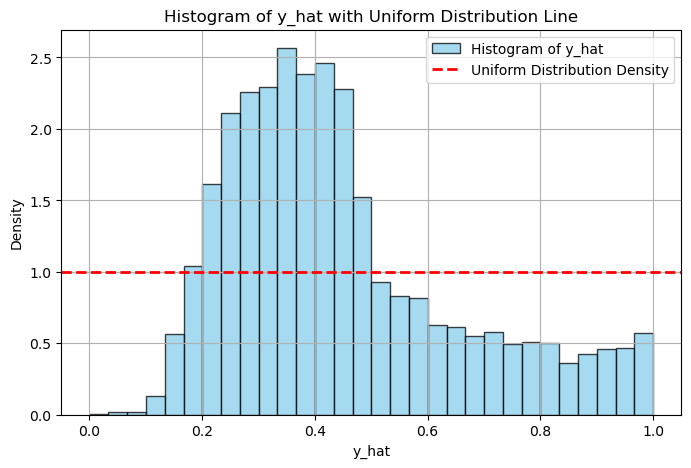

In [13]:
def train_logistic_regression(X, Y, **kwargs):
    # fit_intercept=False since X already has bias term
    model = LogisticRegression(fit_intercept=False, **kwargs)  # intercept pre-built in X
    model.fit(X, Y)
    assert model.classes_[0] == 0 and model.classes_[1] == 1
    return model

model = train_logistic_regression(X_train, Y_train)
# example_thresh = 0.5
# Y_proba = model.predict_proba(X_train)[:,1]
# Y_pred = Y_proba > example_thresh
print(model.coef_)
Y_hat = model.predict_proba(X_train)[:,1]


# Assuming y_hat is already defined and contains values between 0 and 1
# Example: y_hat = np.random.uniform(0, 1, N)

plt.figure(figsize=(8, 5))

# Plot histogram of y_hat
counts, bins, _ = plt.hist(Y_hat, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.75, label='Histogram of y_hat')

# Overlay horizontal line for uniform distribution
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Uniform Distribution Density')

# Labels and legend
plt.xlabel('y_hat')
plt.ylabel('Density')
plt.title('Histogram of y_hat with Uniform Distribution Line')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Compute C_gamma and C: the maximum value of the histogram 
C_gamma = counts.max()
C = args.gamma/C_gamma

In [15]:
# Estimate sigma, the variance of the loss
sigma_sq_base = np.var(Y_hat, ddof=1)
args.sigma_sq = 2 * sigma_sq_base
print(f"Estimated sigma squared: {args.sigma_sq}")


# Estimate B(N,delta/T)

def bernstein_bound(delta, T, n, sigma_sq, R=args.lambda_max/2):
    """Given delta, returns epsilon."""
    # delta, n are given params
    # we need to estimate sigma_sq
    # Thm 2: focus on upper bound
    # https://zcc1307.github.io/courses/csc588sp21/notes/0126.pdf
    delta_prime = delta / T

    return np.sqrt(4 * sigma_sq * np.log(2 / delta_prime) / n) + \
        (4 * R * np.log(2 / delta_prime)) / (3 * n)


Estimated sigma squared: 0.0857038929814903


In [17]:
# Estimate the best T
from scipy.optimize import minimize_scalar

def best_guaranteed_tightness(T):
    delta_lambda = args.lambda_max / T
    return float(2 * bernstein_bound(args.delta, T, args.N, args.sigma_sq)) + \
           2 * args.tau * delta_lambda

result = minimize_scalar(lambda T: best_guaranteed_tightness(T), bounds=(1, 1000), method='bounded')
T_optimal = int(result.x)
tightness_optimal = best_guaranteed_tightness(T_optimal)


# Find the smallest T that achieves the tightness condition
def bin_search_smallest_T():
    low, high = 1, T_optimal
    while low < high:
        mid = (low + high) // 2
        if best_guaranteed_tightness(mid) < args.tightness:
            high = mid
        else:
            low = mid + 1
    return low


if tightness_optimal < args.tightness:
    print(f"Tightness condition is possible to guarantee: {tightness_optimal} < {args.tightness}")
    print(f"Tightest-achieving T: {T_optimal}")

    smallest_T = bin_search_smallest_T()
    print(f"Smallest T that achieves tightness condition: {smallest_T}")

    args.T = smallest_T
    args.delta_lambda = args.lambda_max / args.T
    # args.sigma_sq   # already set

else:
    print(result)
    print(f"Tightness condition cannot be guaranteed: {tightness_optimal} >= {args.tightness}")
    print(f"Tightest-achieving T: {T_optimal}")
    print(f"Please make tightness parameter larger.")


Tightness condition is possible to guarantee: 0.07297732011170344 < 0.08
Tightest-achieving T: 504
Smallest T that achieves tightness condition: 118


# Experiment

In [107]:
def type_II_error(Y, Y_proba, threshold):
    """Y=actual, Y_proba=predicted probability, threshold=threshold"""
    return np.mean((Y == 1) * (Y_proba < 1. - threshold))


def piecewise_fn(Y_proba: np.ndarray, thresh: int):
    # clipping assumes loss btwn 0 and 1

    # lower_bound = (1 - thresh) - 1 / args.L
    # upper_bound = 1 - thresh
    # y = np.where(Y_proba < lower_bound, 1, 
    #              np.where(Y_proba > upper_bound, 0, 
    #                       1 - args.L * (Y_proba - (1 - thresh) + 1 / args.L)))

    # Optimization 1: use np.clip
    assert len(Y_proba.shape) == 1
    return np.clip(1. - args.L * (Y_proba - (1 - thresh)), 0, 1)

    # Optimization 2: compute less
    #assert len(Y_proba.shape) == 1
    #return np.clip(args.L * (1 - thresh - Y_proba), 0, 1)


def piecewise_loss(Y, Y_proba, thresh):
    assert len(Y.shape) == 1
    assert len(Y_proba.shape) == 1
    return ((Y == 1) * piecewise_fn(Y_proba, thresh))

def modify(Y_proba, threshold):
    in_move_range = (Y_proba >= 1 - threshold)
    Y_proba_new = Y_proba.copy()
    Y_proba_new[in_move_range] -= C
    Y_proba_new = np.clip(Y_proba_new, 0, 1)
    return Y_proba_new

In [109]:
def binary_search_solver(objective, lam_low, lam_high, tol=1e-6, max_iter=100):
    if objective(lam_low) <= 0:
        return lam_low
    
    if objective(lam_high) > 0:
        raise ValueError("No crossing found: objective > 0 for all λ in [lam_low, lam_high].")

    for _ in range(max_iter):
        mid = (lam_low + lam_high) / 2.0
        if objective(mid) <= 0:
            lam_high = mid
        else:
            lam_low = mid
        if lam_high - lam_low < tol:
            break
    return lam_high

In [111]:
from tqdm import tqdm

def run_trajectory(Y, Y_proba, verbose=False):

    losses = [0.]
    errs = [0.]
    thresh = args.lambda_max
    threshes = [thresh]

    bound = bernstein_bound(args.delta, args.T, args.N, args.sigma_sq)
    print("bernstein_bound: ", bound)

    iters = tqdm(range(1, args.T + 1)) if verbose else range(1, args.T + 1)
    for t in iters:

        # Deploy threshold
        Y_proba_t = modify(Y_proba, thresh)

        # Calculate loss
        err_t = float(type_II_error(Y, Y_proba_t, thresh))
        errs.append(err_t)
        loss_t = float(np.mean(piecewise_loss(Y, Y_proba_t, thresh)))
        losses.append(loss_t)
            
        # Update threshold
        func = lambda nt: np.mean(piecewise_loss(Y, Y_proba_t, nt)) + args.tau * np.max(thresh-nt, 0) + bound - args.alpha
        #func = lambda nt: np.mean(piecewise_loss(Y, Y_proba_t, nt)) + args.tau * np.abs(thresh-nt) + bound - args.alpha
        new_thresh = binary_search_solver(func, 0, thresh)
        print("Iter {t}: Loss: {loss_t:.4f}, Type II error: {err_t:.4f}, Threshold: {thresh:.4f}, New Threshold: {new_thresh:.4f}".format(t=t, loss_t=loss_t, err_t = err_t, thresh=thresh, new_thresh=new_thresh))
        if new_thresh > thresh - args.delta_lambda:
            threshes.append(new_thresh)
            break

        thresh = new_thresh
        threshes.append(thresh)


    return losses, threshes, errs

### Run

In [114]:
Y_proba = model.predict_proba(X_cv)[:,1]
losses, threshes, errs = run_trajectory(Y_cv, Y_proba)

bernstein_bound:  0.03151652136415028
Iter 1: Loss: 0.0073, Type II error: 0.0000, Threshold: 1.0000, New Threshold: 0.8812
Iter 2: Loss: 0.0497, Type II error: 0.0051, Threshold: 0.8812, New Threshold: 0.8124
Iter 3: Loss: 0.0997, Type II error: 0.0264, Threshold: 0.8124, New Threshold: 0.7753
Iter 4: Loss: 0.1314, Type II error: 0.0480, Threshold: 0.7753, New Threshold: 0.7555
Iter 5: Loss: 0.1487, Type II error: 0.0585, Threshold: 0.7555, New Threshold: 0.7449
Iter 6: Loss: 0.1579, Type II error: 0.0667, Threshold: 0.7449, New Threshold: 0.7392


Text(0, 0.1, 'Guaranteed convergence by T=118')

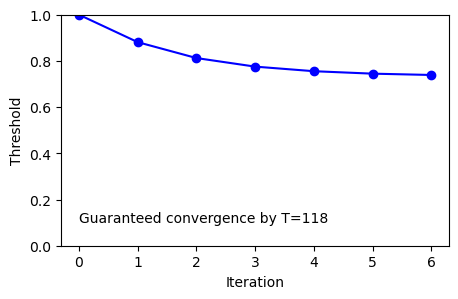

In [116]:
# Plot threshold trajectory
plt.figure(figsize=(5, 3))
plt.ylim(0, args.lambda_max)
plt.plot(threshes, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Threshold')
plt.text(0, 0.1, f"Guaranteed convergence by T={args.T}")

[0.0, 0.007333509902714267, 0.04971465777796466, 0.09966776016377539, 0.13138553510526416, 0.1486599644560566, 0.15786009370649223]
[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
[-inf, -0.07587112332990775, 0.019667507094891984, 0.08072515384569295, 0.1136526010546587, 0.13082874531352187, 0.13968584315629828]


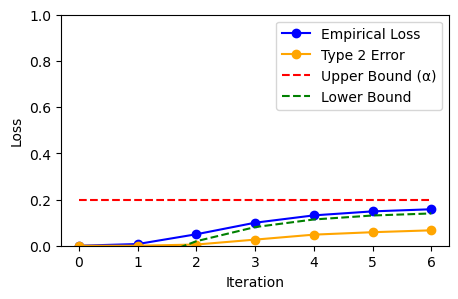

In [118]:
# Plot loss trajectory

upper_bound = [args.alpha for _ in range(len(losses))]
lower_bound = [-np.inf]
for i in range(1, len(losses)):
    delta_lambda = np.maximum(0., threshes[i-1] - threshes[i])
    slack = 2 * bernstein_bound(args.delta, i, args.N, args.sigma_sq) + 2 * args.tau * delta_lambda
    lower_bound.append(float(args.alpha - slack))

print(losses)
print(upper_bound)
print(lower_bound)

plt.figure(figsize=(5, 3))
plt.plot(losses, marker='o', linestyle='-', color='b', label='Empirical Loss')
plt.plot(errs, marker='o', linestyle='-', color='orange', label='Type 2 Error')
plt.plot(upper_bound, linestyle='--', color='r', label='Upper Bound (α)')
plt.plot(lower_bound, linestyle='--', color='g', label='Lower Bound')
plt.ylim(0, 1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [120]:
# Sanity check: Why is blue curve so close to green?

# unfortunately, this is quite large
bernstein_term = bernstein_bound(args.delta, args.T, args.N, args.sigma_sq)
print("bernstein_term: ", bernstein_term)

tau_delta_lambda_term = 2 * args.tau * (threshes[-2] - threshes[-1])
print("tau_delta_lambda_term: ", tau_delta_lambda_term)

print("sum of two terms: ", bernstein_term + tau_delta_lambda_term)

print("L_hat(lambda^{(t-1)}, lambda^{(t)})", args.alpha - (bernstein_term + tau_delta_lambda_term))

print("Hence, empirical loss of 0.1508 is sensible")

bernstein_term:  0.03151652136415028
tau_delta_lambda_term:  0.011407089312423846
sum of two terms:  0.042923610676574124
L_hat(lambda^{(t-1)}, lambda^{(t)}) 0.15707638932342588
Hence, empirical loss of 0.1508 is sensible
